In [1]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Importing packages
from imblearn.over_sampling import SMOTE
from scipy.stats import norm
import pandas as pd # data processing
import numpy as np # working with arrays
from numpy import where
from numpy import mean
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import itertools # construct specialized tools
import matplotlib.pyplot as plt # visualizations
from matplotlib import rcParams # plot size customization
from termcolor import colored as cl # text customization
from sklearn.linear_model import LogisticRegression # model algorithm
from sklearn.preprocessing import StandardScaler # data normalization
from sklearn.metrics import jaccard_score as jss # evaluation metric
from sklearn.metrics import precision_score # evaluation metric
from sklearn.metrics import classification_report # evaluation metric
from sklearn.metrics import confusion_matrix # evaluation metric
from sklearn.metrics import log_loss # evaluation metric
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
# Importing and cleaning the data
train_data = pd.read_csv('DBS.csv', sep=';')
test_data = pd.read_csv('DBS_2020.csv', sep=';')
train_data.head()

,access,tests,tests_grade,exam,project,project_grade,assignments,result_points,result_grade,graduate,year,acad_year
0,1256,57.00,A,19,91.54,A,40.0,189.92,A,1,2019,2019/2020
1,985,42.87,B,19,75.96,A,13.7,189.43,A,1,2017,2017/2018
2,1455,54.50,A,16,96.79,A,40.0,188.91,A,1,2019,2019/2020
3,998,54.50,A,16,93.36,A,40.0,186.85,A,1,2019,2019/2020
4,1347,55.00,A,16,92.86,A,39.0,186.38,A,1,2019,2019/2020


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   access         261 non-null    int64  
 1   tests          261 non-null    float64
 2   tests_grade    261 non-null    object 
 3   exam           261 non-null    int64  
 4   project        261 non-null    float64
 5   project_grade  261 non-null    object 
 6   assignments    261 non-null    float64
 7   result_points  261 non-null    float64
 8   result_grade   261 non-null    object 
 9   graduate       261 non-null    int64  
 10  year           261 non-null    int64  
 11  acad_year      261 non-null    object 
dtypes: float64(4), int64(4), object(4)
memory usage: 24.6+ KB


In [5]:
print('The dataset has {:3,d} samples and {} features'.format(*train_data.shape))

The dataset has 261 samples and 12 features


In [6]:
import seaborn as sns

C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_8968\3667358862.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


<AxesSubplot:>

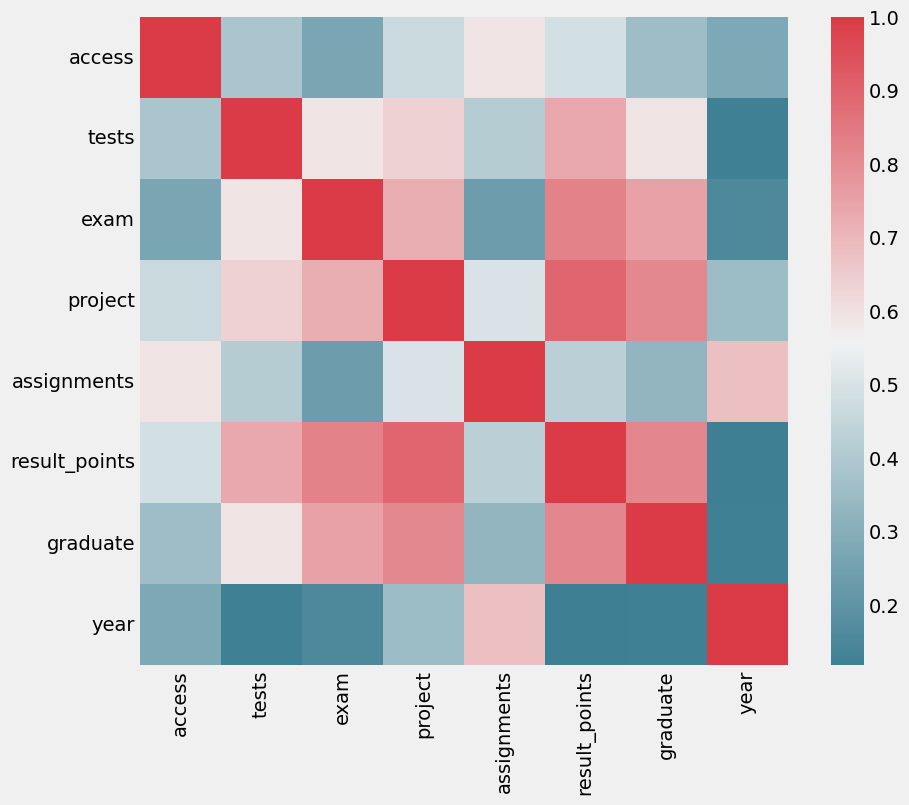

In [7]:
f, ax = plt.subplots(figsize=(10, 8))
corr = train_data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

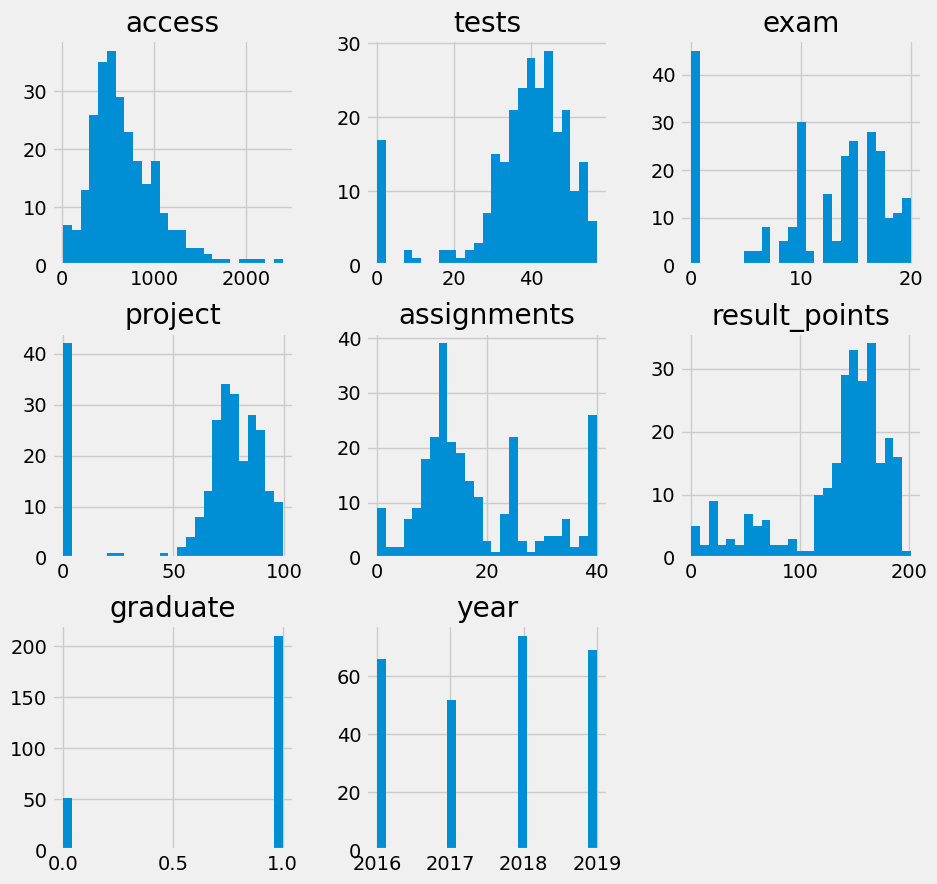

In [8]:
train_data.hist(bins=25,figsize=(10,10))
# display histogram
plt.show()

In [9]:
# Print markdown programatically for better visualization.
def printmd(string):
    display(Markdown(string))

In [10]:
# Plots and creates labels for values plotted. Used for exploration of features.
def plot_and_annotate(train_data, **kwarg):
    ax = train_data['percent'].sort_values().plot(kind='barh', **kwarg)
    for p in ax.patches:
        width = p.get_width()
        plt.text(5 + width, p.get_y() + 0.55 * p.get_height(),
                 '{:1.2f}%'.format(width),
                 ha='center', va='center')


In [11]:
# Creates percentages for value_counts of a pd.series object.
def create_count_percentages(series, name=None):
    values = series.value_counts()
    expanded_value = values.to_frame(name)
    expanded_value['percent'] = values.apply(lambda _: _ / series.size * 100)
    return expanded_value


In [12]:
# Data must be loaded before definin create_plot_data due to inside reference.
def create_plot_data(train_data, feature):
    return create_count_percentages(train_data[feature], name=feature)


In [13]:
def cast_df_features(train_data, feature_catalog):
    def parse_type(dtype):
        if dtype == 'int':
            return np.int8
        elif dtype == 'float':
            return np.float
        else:
            return dtype

    # Make a dict to use as dtypes for panda's dataframe
    features_dtypes = feature_catalog.set_index('feature_name')['pandas_dtype'].apply(parse_type).to_dict()
    # Keep only the columns that remain in the clean version of the dataframe
    features_dtypes = {k: v for k, v in features_dtypes.items() if k in data.columns}
    return train_data.astype(features_dtypes)

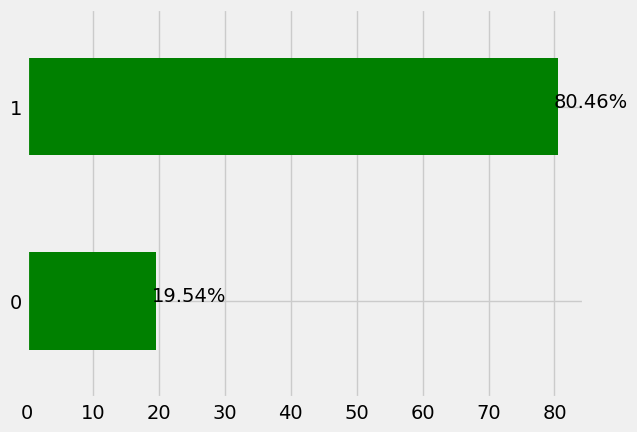

In [14]:
plot_data = create_plot_data(train_data, 'graduate')
plot_and_annotate(plot_data, color='green')

In [15]:
train_data.graduate.value_counts()

1    210
0     51
Name: graduate, dtype: int64

In [16]:
test_data.head()

,access,tests,tests_grade,exam,project,project_grade,assignments,result_points,result_grade,graduate,year,acad_year
0,794,68.10,A,19.40,100.23,A,37,235.34,A,1,2020,2020/2021
1,844,57.85,C,12.57,96.14,A,32,215.75,B,1,2020,2020/2021
2,658,64.60,B,17.57,101.59,A,37,224.27,B,1,2020,2020/2021
3,1193,56.93,C,13.28,102.31,A,36,216.56,B,1,2020,2020/2021
4,1400,61.35,C,15.40,93.72,B,34,214.72,B,1,2020,2020/2021


In [17]:
print(train_data.shape)
print(test_data.shape)
print(list(train_data.columns))

(261, 12)
(60, 12)
['access', 'tests', 'tests_grade', 'exam', 'project', 'project_grade', 'assignments', 'result_points', 'result_grade', 'graduate', 'year', 'acad_year']


In [18]:
train_data['graduate'].value_counts()

1    210
0     51
Name: graduate, dtype: int64

In [19]:
test_data['graduate'].value_counts()

1    46
0    14
Name: graduate, dtype: int64

In [20]:
X_train = np.asarray(train_data[['access', 'tests', 'assignments']])
y_train = np.asarray(train_data['graduate'])

print(cl('X_var samples : ', attrs = ['bold']), X_train[:5])
print(cl('y_var samples : ', attrs = ['bold']), y_train[:5])

X_var samples :  [[1256.     57.     40.  ]
 [ 985.     42.87   13.7 ]
 [1455.     54.5    40.  ]
 [ 998.     54.5    40.  ]
 [1347.     55.     39.  ]]
y_var samples :  [1 1 1 1 1]


In [21]:
X_test = np.asarray(test_data[['access', 'tests', 'assignments']])
y_test = np.asarray(test_data['graduate'])

print(cl('X_var samples : ', attrs = ['bold']), X_test[:5])
print(cl('y_var samples : ', attrs = ['bold']), y_test[:5])

X_var samples :  [[ 794.     68.1    37.  ]
 [ 844.     57.85   32.  ]
 [ 658.     64.6    37.  ]
 [1193.     56.93   36.  ]
 [1400.     61.35   34.  ]]
y_var samples :  [1 1 1 1 1]


In [22]:
# Data normalization with sklearn
from sklearn import preprocessing
standardized_X = preprocessing.scale(X_test)
df = pd.DataFrame(standardized_X)
df.describe()

,0,1,2
count,6.000000e+01,6.000000e+01,6.000000e+01
mean,-1.850372e-17,4.218847e-16,1.591320e-16
std,1.008439e+00,1.008439e+00,1.008439e+00
min,-2.201088e+00,-2.870371e+00,-2.841506e+00
25%,-5.506751e-01,-6.288193e-01,-8.207221e-01
50%,-1.676396e-01,3.510590e-01,2.428486e-01
75%,5.836475e-01,7.641450e-01,8.809911e-01
max,2.820037e+00,1.491048e+00,1.306419e+00


Counter({1: 210, 0: 51})


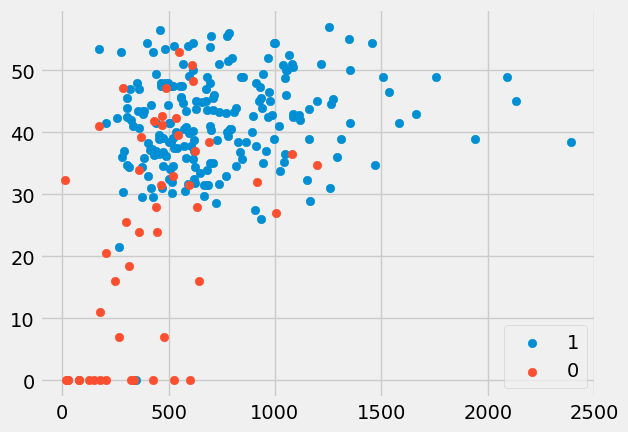

In [23]:
# Summarize class distribution
counter = Counter(y_train)
print(counter)

for label, _ in counter.items():
	row_ix = where(y_train == label)[0]
	plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [24]:
# Data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
# Transform the dataset
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_resample(X_train, y_train) 

In [26]:
# Summarize the new class distribution
counter = Counter(y_train_res)
print(counter)

Counter({1: 210, 0: 210})


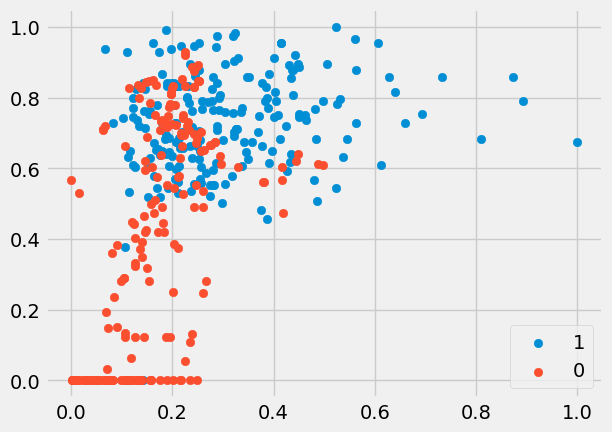

In [27]:
for label, _ in counter.items():
	row_ix = where(y_train_res == label)[0]
	plt.scatter(X_train_res[row_ix, 0], X_train_res[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [28]:
# Modelling
lr1 = LogisticRegression()
lr1.fit(X_train_res, y_train_res)
print(cl(lr1, attrs = ['bold']))

LogisticRegression()


In [29]:
# Evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_val_score(lr1, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.985


In [30]:
# Predictions
yhat = lr1.predict(X_test)
yhat_prob = lr1.predict_proba(X_test)

In [31]:
from sklearn.metrics import mean_absolute_error
def evaluate(lr1, x_scaled, y_test):
    predictions = lr1.predict(x_scaled)
    errors = abs(predictions - y_test)
    mape = mean_absolute_error(predictions, y_test)*100
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

In [32]:
base_accuracy = evaluate(lr1, X_test, y_test)

Model Performance
Average Error: 0.0667 degrees.
Accuracy = 93.33%.


In [33]:
print(y_test)
print(yhat)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0]


In [34]:
# Classificaton report
print(cl(classification_report(y_test, yhat), attrs = ['bold']))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85        14
           1       0.94      0.98      0.96        46

    accuracy                           0.93        60
   macro avg       0.93      0.88      0.90        60
weighted avg       0.93      0.93      0.93        60



Recall metric in the testing dataset: 97.82608695652173%


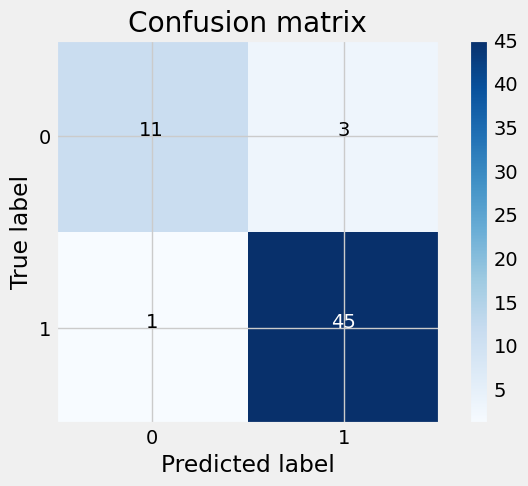

In [35]:
# Confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
y_pre = lr1.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
#print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

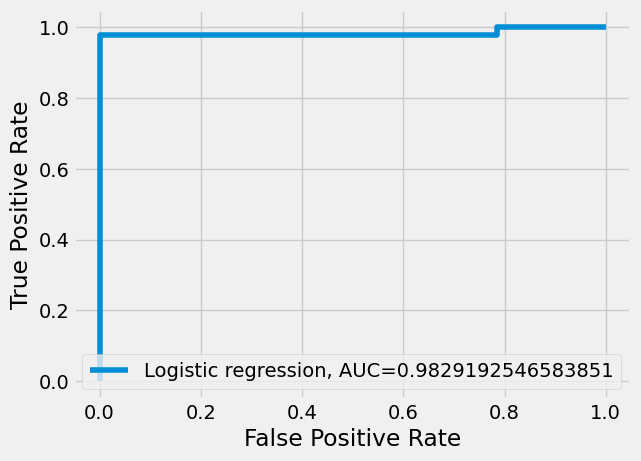

In [36]:
# Import the metrics class
from sklearn import metrics
y_pred_proba = lr1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr,tpr,label="Logistic regression, AUC="+str(auc))
plt.legend(loc=4)
plt.show()

Random (chance) Prediction: AUROC = 0.500
XGBoost: AUROC = 0.983


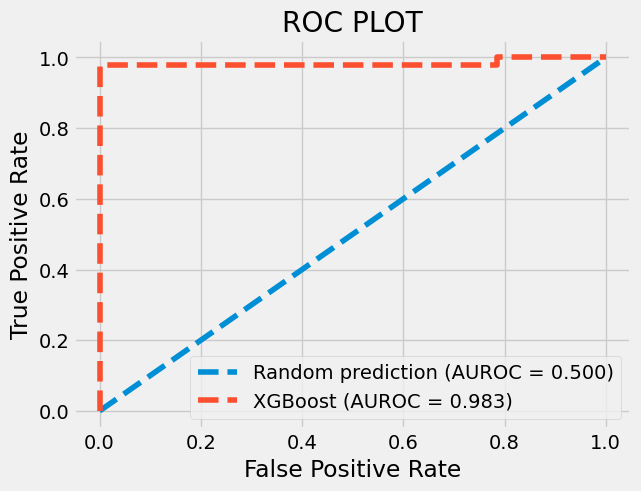

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score
r_probs = [0 for _ in range(len(y_test))]
prob_y_12 = lr1.predict_proba(X_test)

# keep probabilities for the positive outcome only
prob_y_12 = [p[1] for p in prob_y_12]

r_auc = roc_auc_score(y_test, r_probs)
auc1 = roc_auc_score(y_test, prob_y_12)

print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('XGBoost: AUROC = %.3f' % (auc1))

r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
prob_y_12_fpr, prob_y_12_tpr, _ = roc_curve(y_test, prob_y_12)
import matplotlib.pyplot as plt
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(prob_y_12_fpr, prob_y_12_tpr, linestyle='--', label='XGBoost (AUROC = %0.3f)' % auc1)


# Title
plt.title('ROC PLOT')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [38]:
import statsmodels.formula.api as smf

In [39]:
lr1 = smf.logit("graduate ~ access + assignments + tests", data=train_data)
results = lr1.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.309274
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               graduate   No. Observations:                  261
Model:                          Logit   Df Residuals:                      257
Method:                           MLE   Df Model:                            3
Date:                Tue, 11 Jul 2023   Pseudo R-squ.:                  0.3739
Time:                        18:14:12   Log-Likelihood:                -80.721
converged:                       True   LL-Null:                       -128.92
Covariance Type:            nonrobust   LLR p-value:                 9.203e-21
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.8061      0.790     -4.817      0.000      -5.355      -2.257
access          0.0015      0.001      1.642      0.101      -0.000       0.003
assignments     0.0530      0.033      1.623      0.105      -0.011       0.117
tests           0.1028      0.020      5.092      0.000       0.063       0.142
===============================================================================
"""